<a href="https://colab.research.google.com/github/harshit-dxt/deep-learning/blob/main/Facial-Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Kaggle dataset download

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"harshitdixit","key":"0e2f940fd529c8b5558a8f87d0f43f17"}'}

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [ ]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
 ! kaggle datasets list

ref                                                          title                                           size  lastUpdated          downloadCount  
-----------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  
alexgude/california-traffic-collision-data-from-switrs       California Traffic Collision Data from SWITRS    1GB  2020-11-22 16:51:55            597  
babyoda/women-entrepreneurship-and-labor-force               Women Entrepreneurship and Labor Force           1KB  2020-11-21 08:38:51           1818  
szymonjanowski/internet-articles-data-with-users-engagement  Internet news data with readers engagement       3MB  2020-11-21 17:09:57            804  
sakshigoyal7/credit-card-customers                           Credit Card customers                          379KB  2020-11-19 07:38:44           3385  
imoore/2020-us-general-election-turnout-rates                2020 US General Election Tu

In [ ]:
! kaggle datasets download -d nipunarora8/age-gender-and-ethnicity-face-data-csv

 90% 57.0M/63.2M [00:00<00:00, 57.2MB/s]
100% 63.2M/63.2M [00:00<00:00, 81.2MB/s]


In [ ]:
!mkdir train
!unzip age-gender-and-ethnicity-face-data-csv.zip -d train

Archive:  age-gender-and-ethnicity-face-data-csv.zip
  inflating: train/age_gender.csv    


## Importing libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as L
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
import plotly.express as px
tf.random.set_seed(42)

## Reading the dataset

In [ ]:
data = pd.read_csv('./train/age_gender.csv')

In [ ]:
data['pixels'] = data['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32")) # converting pixels into a numpy array

### Peek into the data

In [ ]:
data.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,"[129.0, 128.0, 128.0, 126.0, 127.0, 130.0, 133..."
1,1,2,0,20161219222752047.jpg.chip.jpg,"[164.0, 74.0, 111.0, 168.0, 169.0, 171.0, 175...."
2,1,2,0,20161219222832191.jpg.chip.jpg,"[67.0, 70.0, 71.0, 70.0, 69.0, 67.0, 70.0, 79...."
3,1,2,0,20161220144911423.jpg.chip.jpg,"[193.0, 197.0, 198.0, 200.0, 199.0, 200.0, 202..."
4,1,2,0,20161220144914327.jpg.chip.jpg,"[202.0, 205.0, 209.0, 210.0, 209.0, 209.0, 210..."


In [ ]:
print('Total rows: {}'.format(len(data)))
print('Total columns: {}'.format(len(data.columns)))

Total rows: 23705
Total columns: 5


### Sample images

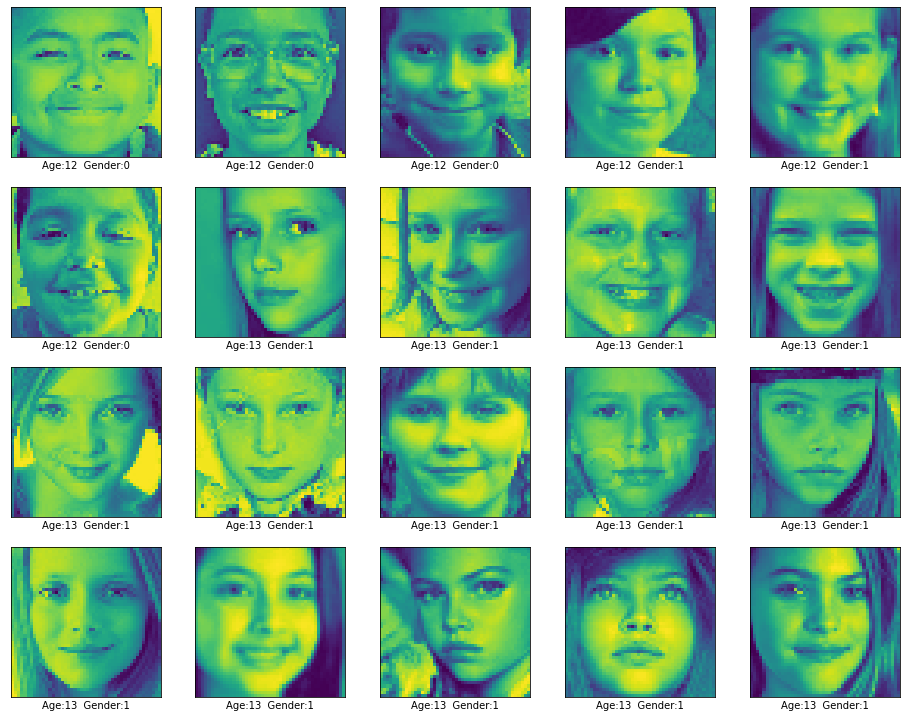

In [ ]:
plt.figure(figsize=(16,16))
for i in range(1500,1520):
    plt.subplot(5,5,(i%25)+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data['pixels'].iloc[i].reshape(48,48))
    plt.xlabel(
        "Age:"+str(data['age'].iloc[i])+
        "  Gender:"+ str(data['gender'].iloc[i])
    )
plt.show()

## Age detection - A regression problem on image dataset

### Normalizing the pixels

In [ ]:
data['pixels'] = data['pixels'].apply(lambda x: x/255) # Min-Max normalisation

### Distribution Plot function

In [ ]:
def distribution_plot(x,y,name):
    fig = go.Figure([
        go.Bar(x=x, y=y)
    ])

    fig.update_layout(title_text=name)
    fig.show()

### Age distribution Plot

In [ ]:
age_dist = data['age'].value_counts()
distribution_plot(x=age_dist.index, y=age_dist.values, name='Age Distribution')

### Train test split and other preprocessing

In [ ]:
X = np.array(data['pixels'].tolist())

"""
Reshaping X into (D, H, W, C) 
D - number of data points
H - Height of image
W - Width of image
C - number of channels in the image
"""

X = X.reshape(X.shape[0], 48, 48, 1) 

y = data['age']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=37, shuffle=True
    )

### Compiling the model

In [ ]:
model = tf.keras.Sequential(name="ReviveNet")
model.add(tf.keras.Input(shape=(48,48,1)))
model.add(L.Conv2D(32, 3, activation='relu'))
model.add(L.BatchNormalization())
model.add(L.MaxPool2D(pool_size=(2,2))),
model.add(L.Conv2D(64, 3, activation='relu'))
model.add(L.MaxPool2D(pool_size=(2,2)))
model.add(L.Conv2D(128, 3, activation='relu'))
model.add(L.MaxPool2D(pool_size=(2,2)))
model.add(L.Flatten())
model.add(L.Dense(64, activation='relu'))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation='relu'))



model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae'])

### Model summary

In [ ]:
print(model.summary())

Model: "ReviveNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 46, 46, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 128)         0 

### Training the model

In [ ]:
history = model.fit(
    X_train, y_train, epochs=20, validation_split=0.1, batch_size=64, #callbacks=[callback]
)

Epoch 1/20
267/267 [==============================] - 2s 8ms/step - loss: 324.9323 - mae: 13.5732 - val_loss: 1141.1042 - val_mae: 28.1914
Epoch 2/20
267/267 [==============================] - 2s 7ms/step - loss: 205.0025 - mae: 10.8059 - val_loss: 395.1454 - val_mae: 15.1383
Epoch 3/20
267/267 [==============================] - 2s 7ms/step - loss: 171.1024 - mae: 9.7368 - val_loss: 163.5464 - val_mae: 9.1214
Epoch 4/20
267/267 [==============================] - 2s 7ms/step - loss: 155.4080 - mae: 9.2125 - val_loss: 119.3870 - val_mae: 7.9853
Epoch 5/20
267/267 [==============================] - 2s 7ms/step - loss: 148.6377 - mae: 9.0390 - val_loss: 105.6691 - val_mae: 7.6591
Epoch 6/20
267/267 [==============================] - 2s 7ms/step - loss: 136.9229 - mae: 8.6285 - val_loss: 158.1749 - val_mae: 10.0799
Epoch 7/20
267/267 [==============================] - 2s 7ms/step - loss: 133.7023 - mae: 8.5609 - val_loss: 157.6411 - val_mae: 10.0013
Epoch 8/20
267/267 [=====================

### Evaluation of training history

In [ ]:

fig = px.line(title='Training History')
fig.add_scatter(x=list(range(1,21)), y=history.history['loss'],mode='lines', name='loss')
fig.add_scatter(x=list(range(1,21)), y=history.history['val_loss'], mode='lines', name='val_loss' )
fig.update_layout(xaxis_title="Epochs",
                  yaxis_title="Loss",
                  )
# fig.add_scatter(history.history, y='val_loss')
fig.show()

### MSE and MAE without callback

In [ ]:
mse, mae = model.evaluate(X_test,y_test,verbose=0)
print('Test Mean squared error: {}'.format(mse))
print('Test Mean absolute error: {}'.format(mae))

Test Mean squared error: 111.28680419921875
Test Mean absolute error: 7.596689701080322


### Callback for this model

In [ ]:
## Stop training when validation loss reach 96
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_loss')<100):
            print("\nReached 96 val_loss so cancelling training!")
            self.model.stop_training = True
        
callback = myCallback()

### Training with call back

In [ ]:
model = tf.keras.Sequential(name="ReviveNet")
model.add(tf.keras.Input(shape=(48,48,1)))
model.add(L.Conv2D(32, 3, activation='relu'))
model.add(L.BatchNormalization())
model.add(L.MaxPool2D(pool_size=(2,2))),
model.add(L.Conv2D(64, 3, activation='relu'))
model.add(L.MaxPool2D(pool_size=(2,2)))
model.add(L.Conv2D(128, 3, activation='relu'))
model.add(L.MaxPool2D(pool_size=(2,2)))
model.add(L.Flatten())
model.add(L.Dense(64, activation='relu'))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation='relu'))

# sgd_optim = tf.keras.optimizers.SGD(momentum=0.9)

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae'])

history = model.fit(
    X_train, y_train, epochs=20, validation_split=0.1, batch_size=64, callbacks=[callback]
)

Epoch 1/20
267/267 [==============================] - 2s 7ms/step - loss: 360.6130 - mae: 14.4765 - val_loss: 1241.3132 - val_mae: 29.5232
Epoch 2/20
267/267 [==============================] - 2s 7ms/step - loss: 231.6031 - mae: 11.5513 - val_loss: 343.5871 - val_mae: 13.7625
Epoch 3/20
267/267 [==============================] - 2s 7ms/step - loss: 197.3925 - mae: 10.4977 - val_loss: 146.7578 - val_mae: 9.5389
Epoch 4/20
267/267 [==============================] - 2s 7ms/step - loss: 176.3733 - mae: 9.8388 - val_loss: 113.9350 - val_mae: 8.0631
Epoch 5/20
267/267 [==============================] - 2s 6ms/step - loss: 166.1112 - mae: 9.5060 - val_loss: 209.5546 - val_mae: 10.4842
Epoch 6/20
267/267 [==============================] - 2s 7ms/step - loss: 153.9618 - mae: 9.1861 - val_loss: 157.0912 - val_mae: 9.0705
Epoch 7/20
267/267 [==============================] - 2s 7ms/step - loss: 151.3595 - mae: 9.0586 - val_loss: 131.1588 - val_mae: 8.8443
Epoch 8/20
267/267 [=====================

### MSE and MAE with callback

In [ ]:
mse, mae = model.evaluate(X_test,y_test,verbose=0)
print('Test Mean squared error: {}'.format(mse))
print('Test Mean absolute error: {}'.format(mae))

Test Mean squared error: 95.84571075439453
Test Mean absolute error: 7.352696418762207


## Gender Prediction

### Gender distribution plot

In [ ]:
gender_dist = data['gender'].value_counts().rename(index={0:'Male',1:'Female'})
distribution_plot(x=gender_dist.index, y=gender_dist.values, name='Gender Distribution')

### Train test split and other preprocessing

In [ ]:
y = data['gender']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=37
)

### Compiling the model

In [ ]:
model = tf.keras.Sequential(name="SapiensNet")
model.add(tf.keras.Input(shape=(48,48,1)))
model.add(L.Conv2D(32, 3, activation='relu'))
model.add(L.BatchNormalization())
model.add(L.MaxPool2D(pool_size=(2,2))),
model.add(L.Conv2D(64, 3, activation='relu'))
model.add(L.MaxPool2D(pool_size=(2,2)))
model.add(L.Flatten())
model.add(L.Dense(64, activation='relu'))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation='sigmoid'))

sgd = tf.keras.optimizers.SGD(momentum=0.9)
model.compile(optimizer='sgd',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

### Summary of the model

In [ ]:
print(model.summary())

Model: "SapiensNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 46, 46, 32)        320       
_________________________________________________________________
batch_normalization_4 (Batch (None, 46, 46, 32)        128       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 10, 10, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4

### Training the model

In [ ]:
history = model.fit(
    X_train, y_train, epochs=40, validation_split=0.1, batch_size=64,
)

Epoch 1/40
267/267 [==============================] - 2s 7ms/step - loss: 0.5353 - accuracy: 0.7268 - val_loss: 0.5894 - val_accuracy: 0.8060
Epoch 2/40
267/267 [==============================] - 2s 6ms/step - loss: 0.4029 - accuracy: 0.8163 - val_loss: 0.3975 - val_accuracy: 0.8334
Epoch 3/40
267/267 [==============================] - 2s 6ms/step - loss: 0.3581 - accuracy: 0.8423 - val_loss: 0.3407 - val_accuracy: 0.8492
Epoch 4/40
267/267 [==============================] - 2s 6ms/step - loss: 0.3333 - accuracy: 0.8513 - val_loss: 0.3236 - val_accuracy: 0.8614
Epoch 5/40
267/267 [==============================] - 2s 6ms/step - loss: 0.3170 - accuracy: 0.8581 - val_loss: 0.3264 - val_accuracy: 0.8603
Epoch 6/40
267/267 [==============================] - 2s 6ms/step - loss: 0.3057 - accuracy: 0.8678 - val_loss: 0.3398 - val_accuracy: 0.8487
Epoch 7/40
267/267 [==============================] - 2s 6ms/step - loss: 0.2957 - accuracy: 0.8713 - val_loss: 0.3059 - val_accuracy: 0.8687
Epoch 

### Evaluation of training history

In [ ]:
fig = px.line(title='Training History')
fig.add_scatter(x=list(range(1,21)), y=history.history['loss'],mode='lines', name='loss')
fig.add_scatter(x=list(range(1,21)), y=history.history['val_loss'], mode='lines', name='val_loss' )
fig.update_layout(xaxis_title="Epochs",
                  yaxis_title="Loss",
                  )
# fig.add_scatter(history.history, y='val_loss')
fig.show()

### Test accuracy and loss

In [ ]:
loss, acc = model.evaluate(X_test,y_test,verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test loss: 0.24889977276325226
Test Accuracy: 0.9000210762023926


### Callback for this model

In [ ]:
## Stop training when validation loss reach 0.2700
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_loss')<0.2700):
            print("\nReached 0.2700 val_loss so cancelling training!")
            self.model.stop_training = True
        
callback = myCallback()

### Model training with callback

In [ ]:
model = tf.keras.Sequential(name="SapiensNet")
model.add(tf.keras.Input(shape=(48,48,1)))
model.add(L.Conv2D(32, 3, activation='relu'))
model.add(L.BatchNormalization())
model.add(L.MaxPool2D(pool_size=(2,2))),
model.add(L.Conv2D(64, 3, activation='relu'))
model.add(L.MaxPool2D(pool_size=(2,2)))
model.add(L.Flatten())
model.add(L.Dense(64, activation='relu'))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation='sigmoid'))

sgd = tf.keras.optimizers.SGD(momentum=0.9)
model.compile(optimizer='sgd',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
history = model.fit(
    X_train, y_train, epochs=20, validation_split=0.1, batch_size=64, callbacks=[callback]
)

Epoch 1/20
267/267 [==============================] - 53s 200ms/step - loss: 0.5250 - accuracy: 0.7376 - val_loss: 0.5998 - val_accuracy: 0.7881
Epoch 2/20
267/267 [==============================] - 53s 199ms/step - loss: 0.4026 - accuracy: 0.8198 - val_loss: 0.4114 - val_accuracy: 0.8413
Epoch 3/20
267/267 [==============================] - 53s 200ms/step - loss: 0.3575 - accuracy: 0.8413 - val_loss: 0.3403 - val_accuracy: 0.8519
Epoch 4/20
267/267 [==============================] - 53s 200ms/step - loss: 0.3303 - accuracy: 0.8545 - val_loss: 0.3131 - val_accuracy: 0.8645
Epoch 5/20
267/267 [==============================] - 54s 202ms/step - loss: 0.3139 - accuracy: 0.8614 - val_loss: 0.3135 - val_accuracy: 0.8640
Epoch 6/20
267/267 [==============================] - 54s 202ms/step - loss: 0.3037 - accuracy: 0.8649 - val_loss: 0.2966 - val_accuracy: 0.8698
Epoch 7/20
267/267 [==============================] - 54s 203ms/step - loss: 0.2893 - accuracy: 0.8738 - val_loss: 0.2910 - val_ac

### Test accuracy and loss

In [ ]:
loss, acc = model.evaluate(X_test,y_test,verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test loss: 0.2564677894115448
Test Accuracy: 0.8854671716690063
